In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

sns.set()

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.head()

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,0,-2.033875,0.978446,-0.142131,-0.177117,-1.470684,1.669562,-0.196530,-0.125239,-0.452284,...,-1.111266,0.716084,0.060039,0.301279,-1.174846,-1.076498,-0.069452,-0.604012,-2.179176,0.558003
1,1,-0.348835,0.294815,-0.557577,-2.020773,-1.234715,1.633930,-1.680658,-0.358146,0.166122,...,0.735240,0.829781,1.521941,1.347946,0.754505,1.330642,-0.754453,0.582956,0.252671,1.495870
2,1,0.113248,-0.607726,-0.947791,0.830851,0.998291,0.498321,-1.493958,0.789572,-1.311018,...,0.104698,0.616189,-1.035953,2.111387,-0.984415,1.148076,-1.433554,0.243372,0.170083,1.274795
3,0,1.223321,-0.479048,-1.925789,1.680377,0.021840,-1.453307,0.605559,-0.019024,1.065448,...,0.360237,-1.957863,-0.123384,1.505329,0.660290,-1.769443,-0.547756,-0.568122,0.244645,0.982116
4,0,0.160109,0.422684,-0.308029,0.227744,0.432854,0.608348,0.193832,1.035091,-0.538868,...,0.416629,1.441766,0.212572,-0.994721,1.143999,-2.166923,-1.199248,-1.028636,0.752791,0.317169


In [5]:
data.isnull().sum()

labels    0
f_0       0
f_1       0
f_2       0
f_3       0
         ..
f_1195    0
f_1196    0
f_1197    0
f_1198    0
f_1199    0
Length: 1201, dtype: int64

In [6]:
data.shape

(5250, 1201)

In [7]:
dep = data["labels"]
indep = data.drop(columns=["labels"])

In [18]:
test_data = pd.read_csv("test.csv")
test_data.head()

,id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,1,-3.388242,0.868285,-0.427619,-0.678964,-1.625735,0.262761,1.243040,1.537751,-0.352028,...,-0.776403,-0.662884,-0.257091,-1.168413,0.223260,-0.482520,-0.085453,-0.382265,-0.539349,-1.682404
1,2,-0.496920,0.952381,0.989040,0.451422,0.513516,-0.099658,-1.124326,0.729430,-0.216224,...,0.379635,-1.760084,1.125450,-0.328047,-0.880305,-1.257607,0.964312,2.021104,0.655021,-0.423029
2,3,1.128369,-0.537951,2.544358,1.165254,-1.904994,0.776961,-0.495768,0.060111,-1.418468,...,1.165254,-1.373589,-0.483701,-0.964782,-0.869555,0.066040,-0.444567,-0.531935,-0.878660,1.099488
3,4,0.051253,1.746814,0.681177,1.844524,-0.327977,1.226839,-0.085519,0.379008,-1.003667,...,-0.442288,-2.794472,-0.763468,-0.789832,-0.113209,-2.703150,-2.058728,1.070627,-0.458045,-0.435825
4,5,1.423209,-0.983594,-1.694170,1.197507,1.044211,0.518777,-0.298612,-0.365174,0.738447,...,-2.624450,-3.200223,0.711422,-0.190394,0.337224,-1.656639,0.707360,-0.562290,1.471181,-0.192000


In [19]:
test_indep = test_data.drop(columns = ['id'])

In [20]:
final_df = pd.DataFrame()
final_df = test_data[["id"]]
test_data.drop(columns=["id"], inplace= True)
final_df

,id
0,1
1,2
2,3
3,4
4,5
...,...
2245,2246
2246,2247
2247,2248
2248,2249


In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.998:                 
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True 

In [22]:
callbacks = myCallback()

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)


model.compile(optimizer=tf.keras.optimizers.Adam(), 
loss= "binary_crossentropy", 
metrics=['accuracy'])


In [12]:
history = model.fit(indep, dep, epochs=50, callbacks=[callbacks])

Epoch 1/50
165/165 [==============================] - 6s 5ms/step - loss: 0.3372 - accuracy: 0.8406
Epoch 2/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0886 - accuracy: 0.9739
Epoch 3/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0146 - accuracy: 0.9973
Epoch 4/50
151/165 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 0.9998
Reached 99% accuracy so cancelling training!
165/165 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.9998


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               307456    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 348,673
Trainable params: 348,673
Non-trainable params: 0
_________________________________________________________________


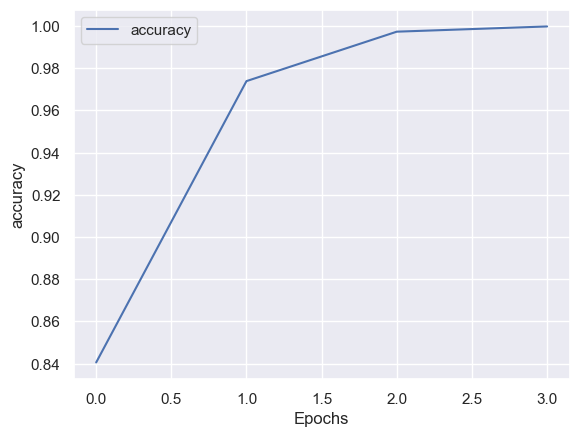

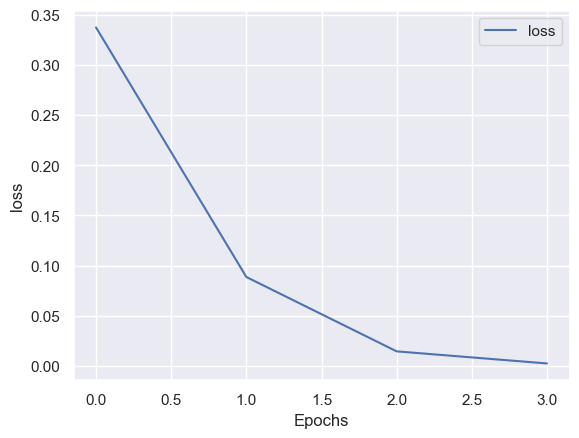

In [23]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [24]:
model_predictions = model.predict(test_indep)

lis = []

for x in model_predictions:
    if x > 0.5:
        lis.append(1)
    else:
        lis.append(0)
lis

71/71 [==============================] - 0s 2ms/step


[1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,


In [25]:
my_series = pd.Series(lis)
final_df["labels"] = lis

final_df

C:\Users\haris\AppData\Local\Temp\ipykernel_8992\959362348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = lis


,id,labels
0,1,1
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
2245,2246,1
2246,2247,1
2247,2248,1
2248,2249,1


In [26]:
final_df.to_csv("Final_Output.csv", index = False)

# DECISION TREE

In [28]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)
drugTree

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [29]:
drugTree.fit(indep, dep)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [30]:
predTree = drugTree.predict(test_indep)

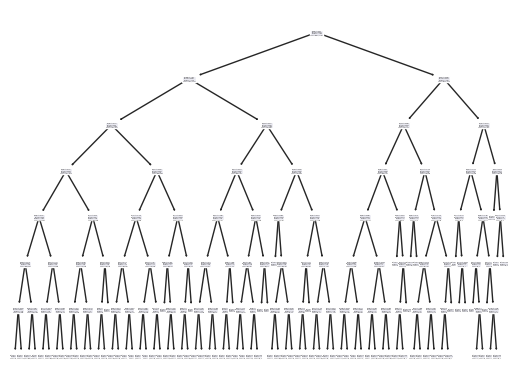

In [32]:
tree.plot_tree(drugTree)
plt.show()

In [34]:
my_series = pd.Series(predTree)
final_df["labels"] = predTree

final_df

C:\Users\haris\AppData\Local\Temp\ipykernel_8992\3614248246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = predTree


,id,labels
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [35]:
final_df.to_csv("Final_Output_Decision Tree.csv", index = False)

# XGBOOST ALGO

In [36]:
import xgboost as xgb

In [37]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'eta': 0.1
}

num_rounds = 100
model = xgb.train(params, indep, num_rounds)

y_pred = model.predict(test_indep)
y_pred_binary = [round(value) for value in y_pred]

TypeError: ('invalid cache item: DataFrame', [           f_0       f_1       f_2       f_3       f_4       f_5       f_6   
0    -2.033875  0.978446 -0.142131 -0.177117 -1.470684  1.669562 -0.196530  \
1    -0.348835  0.294815 -0.557577 -2.020773 -1.234715  1.633930 -1.680658   
2     0.113248 -0.607726 -0.947791  0.830851  0.998291  0.498321 -1.493958   
3     1.223321 -0.479048 -1.925789  1.680377  0.021840 -1.453307  0.605559   
4     0.160109  0.422684 -0.308029  0.227744  0.432854  0.608348  0.193832   
...        ...       ...       ...       ...       ...       ...       ...   
5245  1.157565 -0.142219  1.043992  1.144946  1.195423  0.248978 -1.505100   
5246  1.424709  0.235910  1.356778  1.368099 -0.318862  1.039765 -0.986854   
5247 -0.375687  1.524455  0.012514 -0.007917  0.073809 -0.906909 -1.254247   
5248 -0.478238  1.666142  0.049609 -0.428752 -0.362771  1.798104 -0.214314   
5249 -0.750874  0.267008 -0.155041 -0.179867 -0.155041 -0.303999 -0.279173   

           f_7       f_8       f_9  ...    f_1190    f_1191    f_1192   
0    -0.125239 -0.452284 -0.128052  ... -1.111266  0.716084  0.060039  \
1    -0.358146  0.166122 -1.656990  ...  0.735240  0.829781  1.521941   
2     0.789572 -1.311018  0.848524  ...  0.104698  0.616189 -1.035953   
3    -0.019024  1.065448  0.717341  ...  0.360237 -1.957863 -0.123384   
4     1.035091 -0.538868  0.778445  ...  0.416629  1.441766  0.212572   
...        ...       ...       ...  ...       ...       ...       ...   
5245 -0.874137 -1.782724  0.261597  ...  1.195423 -0.255793 -0.154838   
5246 -0.330184 -1.383120  1.243559  ...  1.424709 -1.066107  0.881258   
5247  1.606182  0.298557  0.053378  ... -0.028349 -0.968204 -1.233815   
5248  0.775400 -0.379267  0.725914  ... -0.428752 -1.121552 -0.379267   
5249  1.731765  0.564925  1.508328  ... -0.303999 -0.850180  0.937321   

        f_1193    f_1194    f_1195    f_1196    f_1197    f_1198    f_1199  
0     0.301279 -1.174846 -1.076498 -0.069452 -0.604012 -2.179176  0.558003  
1     1.347946  0.754505  1.330642 -0.754453  0.582956  0.252671  1.495870  
2     2.111387 -0.984415  1.148076 -1.433554  0.243372  0.170083  1.274795  
3     1.505329  0.660290 -1.769443 -0.547756 -0.568122  0.244645  0.982116  
4    -0.994721  1.143999 -2.166923 -1.199248 -1.028636  0.752791  0.317169  
...        ...       ...       ...       ...       ...       ...       ...  
5245  0.413029 -0.482939 -1.277953 -0.445082  1.195423 -0.924614 -0.432462  
5246 -0.488691 -1.281223 -1.213291  0.122692  1.175627 -1.145360  0.451026  
5247  1.626613 -0.191802  1.115823  0.380284 -0.293960  0.135104  1.381434  
5248 -0.593705  0.049609  1.765114  0.313533 -0.329781 -1.220524  0.033114  
5249 -1.594972  1.036626  1.582807  1.036626 -0.254346  0.664230  1.831071  

[5250 rows x 1200 columns]])

In [38]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100
)

# Train the XGBoost model
model.fit(indep, dep)

# Make predictions on the test set
y_pred = model.predict(test_indep)

In [39]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [40]:
my_series = pd.Series(y_pred)
final_df["labels"] = y_pred

final_df

C:\Users\haris\AppData\Local\Temp\ipykernel_8992\2965317023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = y_pred


,id,labels
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [ ]:
final_df.to_csv("Final_Output_XGBOOST.csv", index = False)

# LOGISTIC REGRESSION

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(indep,dep)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [80]:
yhat = LR.predict(test_indep)
yhat

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [81]:
yhat_prob = LR.predict_proba(test_indep)
yhat_prob

array([[6.62993695e-01, 3.37006305e-01],
       [6.58749131e-01, 3.41250869e-01],
       [5.83685935e-01, 4.16314065e-01],
       ...,
       [3.77574312e-02, 9.62242569e-01],
       [9.99959692e-01, 4.03077015e-05],
       [1.67639526e-01, 8.32360474e-01]])

In [82]:
from sklearn.metrics import jaccard_score
jaccard_score(test_dep, yhat,pos_label=0)

0.42276422764227645

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(test_dep, yhat, labels=[1,0]))

[[282 883]
 [253 832]]


Confusion matrix, without normalization
[[282 883]
 [253 832]]


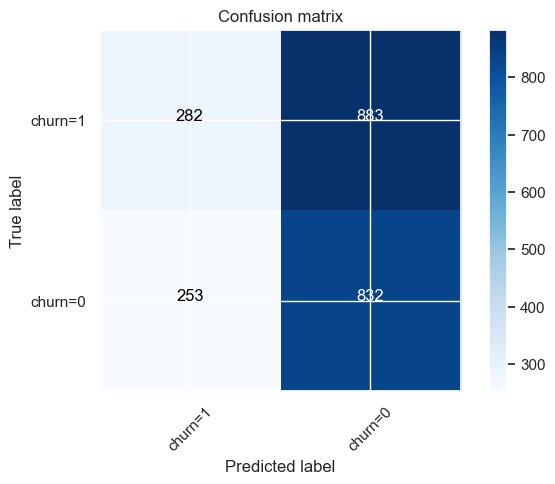

In [84]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_dep, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')